In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.models import Model
from random import randint 

from keras import backend as K 
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D 
from keras.callbacks import TensorBoard 
from tensorflow.keras import layers, losses

def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image itself as the target label

def map_func(sample):
    image = sample['image']
    label = sample['label']
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

import tensorflow_datasets as tfds

# Corrected file path with escaped backslashes and a missing comma
ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:10%]', 'test[:2.5%]', 'validation[:2.5%]'],
                         data_dir=r'C:\Job_og_eksamensbevis\Github\projekter\Projekt_1_Computer_Vision',
                         download=False,
                         shuffle_files=True)

train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

train_dataset_cnn       = ds1.map(map_func).batch(32)
validation_dataset_cnn  = ds3.map(map_func).batch(32)
test_dataset_cnn        = ds2.map(map_func).batch(32)

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Dropout, Conv2DTranspose 

AssertionError: Dataset patch_camelyon: could not find data in C:\Users\bruno\OneDrive\Skrivebord\Data Sciece Kandidat\3 semester\Anvendt machine learning\Eksamen\patch_camelyon. Please make sure to call dataset_builder.download_and_prepare(), or pass download=True to tfds.load() before trying to access the tf.data.Dataset object.

In [3]:

import tensorflow.compat.v1 as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part
class Encoder(tf.keras.layers.Layer): #initialiserer encoderen, definerer lagene og præciserer hvordan vores model skal konstrueres
    def __init__(self, latent_dim): 
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x): #den faktiske model der forward pass'er data og transformerer det på baggrund af hvad der er defineret i def _init_
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3)  # Assuming PCAM images are of shape 96x96x3

# Instantiate the VAE
vae = VAE(latent_dim, original_shape)

# Compile the model
vae.compile(optimizer='adam', loss=MeanSquaredError())

# Freeze the layers in the encoder
vae.encoder.conv1.trainable = False
vae.encoder.maxpool1.trainable = False
vae.encoder.conv2.trainable = False
vae.encoder.maxpool2.trainable = False
vae.encoder.flatten.trainable = False
vae.encoder.dense_mean.trainable = False
vae.encoder.dense_log_var.trainable = False


vae.fit(
        train_dataset,
        epochs=5,  # You can adjust the number of epochs
        validation_data=validation_dataset
)


Epoch 1/5



820/820 [==============================] - 308s 373ms/step - loss: 0.0352 - val_loss: 0.0340
Epoch 2/5
820/820 [==============================] - 303s 369ms/step - loss: 0.0293 - val_loss: 0.0306
Epoch 3/5
820/820 [==============================] - 305s 372ms/step - loss: 0.0274 - val_loss: 0.0296
Epoch 4/5
820/820 [==============================] - 308s 375ms/step - loss: 0.0269 - val_loss: 0.0293
Epoch 5/5
820/820 [==============================] - 307s 374ms/step - loss: 0.0266 - val_loss: 0.0294


In [6]:

def build_cnn(vae, latent_dim):
    # Create a new input layer that matches the original input
    cnn_input = layers.Input(shape=original_shape)

    # Get the mean vector from the encoder
    mean, _ = vae.encoder(cnn_input)

    # Build CNN layers for classification
    x = Dense(128, activation='relu')(mean)  # Processing the mean vector
    x = Dense(64, activation="relu")(x)
    cnn_output = Dense(2, activation="softmax")(x)  # Output layer for 2 classes

    # Create model
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
    
    return cnn_model


In [1]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2

def build_cnn(vae, original_shape, l2_lambda=0.01):
    # Create a new input layer that matches the original input
    cnn_input = layers.Input(shape=original_shape)

    # Print the shape of cnn_input
    print("Shape of cnn_input:", cnn_input.shape)

    # Get the mean vector from the encoder
    mean, _ = vae.encoder(cnn_input)

    # Initialize 'x' with the input tensor
    x = cnn_input

    # Build CNN layers for classification
    x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)

    # Flatten the output of the CNN before feeding into dense layers
    x = Flatten()(x)

    # Combine with mean vector - if necessary, reshape or process 'mean' to match dimensions
    x = layers.concatenate([x, mean])

    # Continue with dense layers with L2 regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    cnn_output = Dense(2, activation="softmax", kernel_regularizer=l2(l2_lambda))(x)  # Output layer for 2 classes

    # Create model
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
    
    print("Shape of cnn_input:", cnn_input.shape)
    
    return cnn_model


In [2]:
#-------> ved ikke om den her del er nødvendig, tror Original shape var den her del skal være defineret for at resten virker

latent_dim = 128  # or whatever your latent dimension is
original_shape = (96, 96, 3)  # Assuming this is the shape of your input data
cnn_model = build_cnn(vae, original_shape)



NameError: name 'vae' is not defined

In [3]:
#------> Igen her er latent dim ændret til original shape. Original shape = 96,96,3
# Build and compile the CNN model
cnn_model = build_cnn(vae, original_shape)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN model
history = cnn_model.fit(
    train_dataset_cnn,  # Your training dataset
    epochs=20,          # Adjust the number of epochs as needed
    validation_data=validation_dataset_cnn  # Your validation dataset
)

NameError: name 'vae' is not defined

In [9]:
# If you have the model defined as 'vae', you can print the model summary
print(vae.summary())

# If you have a dataset or a data generator, you can check the shape of the data
# Assuming `train_dataset_cnn` is your training dataset
for data, _ in train_dataset_cnn.take(1):
    print("Shape of the data being fed into the model:", data.shape)


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           ((None, 128),             9456832   
                              (None, 128))                       
                                                                 
 decoder (Decoder)           multiple                  3587715   
                                                                 
Total params: 13044547 (49.76 MB)
Trainable params: 3587715 (13.69 MB)
Non-trainable params: 9456832 (36.07 MB)
_________________________________________________________________
None
Shape of the data being fed into the model: (32, 96, 96, 3)


In [29]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset_cnn)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")


26/26 [==============================] - 1s 39ms/step - loss: 0.7715 - accuracy: 0.6801
Test accuracy: 0.6800976991653442, Test loss: 0.7715429663658142


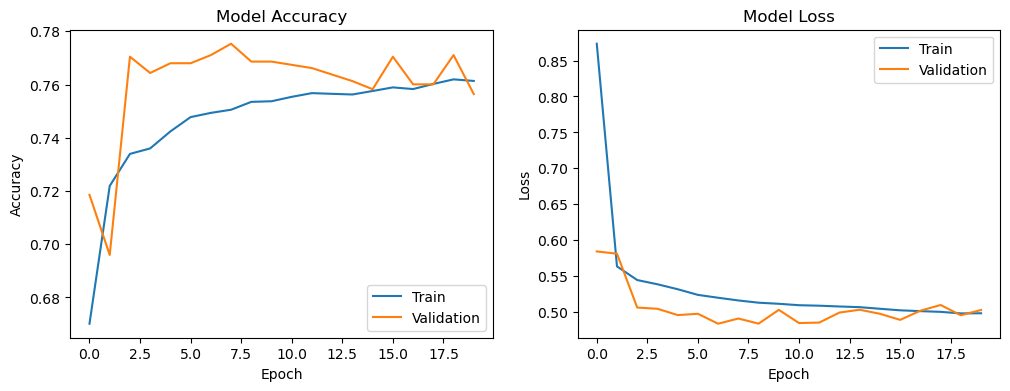

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()